In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Dropout
import math


In [2]:
dataset = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/daily-min-temperatures.csv', index_col='Date')

In [3]:
dataset.index = pd.to_datetime(dataset.index.values)

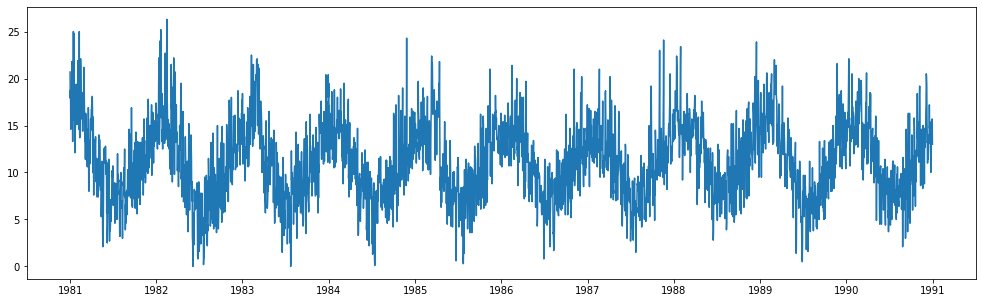

In [4]:
plt.figure(figsize=(17,5))
sns.lineplot(x=dataset.index.values, y=dataset.Temp.values)
plt.show()

In [10]:
def partitionData(data):
    train_len = math.ceil(data.shape[0]*.8) 
    test_len = math.ceil(data.shape[0] - train_len)
    train, test = data[:train_len], data[train_len:]
    train = np.array(np.split(train, train_len/10))
    test = np.array(np.split(test, test_len/10))
    return train, test

In [11]:
def inputData(train, input, out):
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    debut = 0
    for _ in range(len(data)):
        expliquee = debut + input
        out_end = expliquee + out
        if out_end < len(data):
            x_input = data[debut:expliquee, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[expliquee:out_end, 0])
        debut += 1
    return np.array(X), np.array(y)

In [12]:
train, test = partitionData(dataset.values)

In [13]:
train_x, train_y = inputData(train, 10, 10)
print(train_x[0])
print(train_y[0])

[[20.7]
 [17.9]
 [18.8]
 [14.6]
 [15.8]
 [15.8]
 [15.8]
 [17.4]
 [21.8]
 [20. ]]
[16.2 13.3 16.7 21.5 25.  20.7 20.6 24.8 17.7 15.5]


In [14]:
verbose, epochs, batch_size = 1, 30, 30
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]

In [16]:
model = Sequential()
model.add(Bidirectional(LSTM(200, activation='relu',return_sequences=True, input_shape=(n_timesteps, n_features))))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(200, activation='relu', input_shape=(n_timesteps, n_features))))
model.add(Dense(n_outputs))
model.compile(optimizer='adam', loss='mse')

history = model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose, validation_split=0.2)

Epoch 1/30
78/78 [==============================] - 10s 87ms/step - loss: 18.8368 - val_loss: 8.9322
Epoch 2/30
78/78 [==============================] - 6s 81ms/step - loss: 9.2176 - val_loss: 9.0257
Epoch 3/30
78/78 [==============================] - 6s 81ms/step - loss: 9.2379 - val_loss: 8.6336
Epoch 4/30
78/78 [==============================] - 6s 82ms/step - loss: 9.2907 - val_loss: 9.1612
Epoch 5/30
78/78 [==============================] - 6s 82ms/step - loss: 9.2475 - val_loss: 8.7664
Epoch 6/30
78/78 [==============================] - 6s 83ms/step - loss: 9.0301 - val_loss: 8.4474
Epoch 7/30
78/78 [==============================] - 6s 82ms/step - loss: 8.9257 - val_loss: 9.1006
Epoch 8/30
78/78 [==============================] - 6s 82ms/step - loss: 8.9861 - val_loss: 8.5360
Epoch 9/30
78/78 [==============================] - 6s 82ms/step - loss: 8.9604 - val_loss: 8.4979
Epoch 10/30
78/78 [==============================] - 6s 83ms/step - loss: 8.9332 - val_loss: 8.3542
Epoch 1

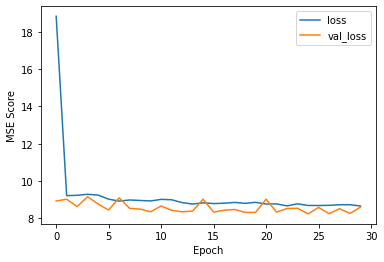

In [19]:
plt.plot(history.history["loss"],label="loss")
plt.plot(history.history["val_loss"],label="val_loss")
plt.legend(loc="best")
plt.xlabel("Epoch")
plt.ylabel("MSE Score")
plt.show()

In [20]:
def prediction(model, history, n_input):
    data = np.array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    input_x = data[-n_input:, 0]
    input_x = input_x.reshape((1, len(input_x), 1))
    yhat = model.predict(input_x, verbose=0)
    yhat = yhat[0]
    return yhat

history = [x for x in train]
predictions = list()
n_input = 10

In [21]:
for i in range(len(test)):
    yhat_sequence = prediction(model, history, n_input)
    predictions.append(yhat_sequence)
    history.append(test[i, :])

In [22]:
predictions = np.array(predictions)
y_pred = predictions.flatten()
y_test = test.flatten()

from sklearn.metrics import mean_squared_error, r2_score
rmse_lstm = np.sqrt(mean_squared_error(y_test, y_pred))
print(rmse_lstm)

2.807167600522416


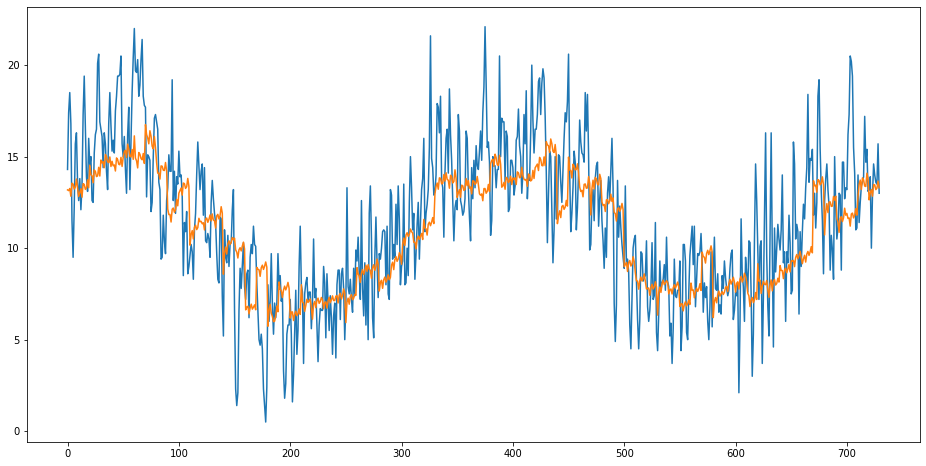

In [23]:
plt.figure(figsize=(16, 8))
plt.plot(y_test, label='true')
plt.plot(y_pred, label='predicted')
plt.show()

In [24]:
next_pred = y_pred

curr_predictor = test[-1].reshape(1,10,1)
curr_prediction = model.predict(curr_predictor)
for x in curr_prediction:
    next_pred = np.append(next_pred, x)

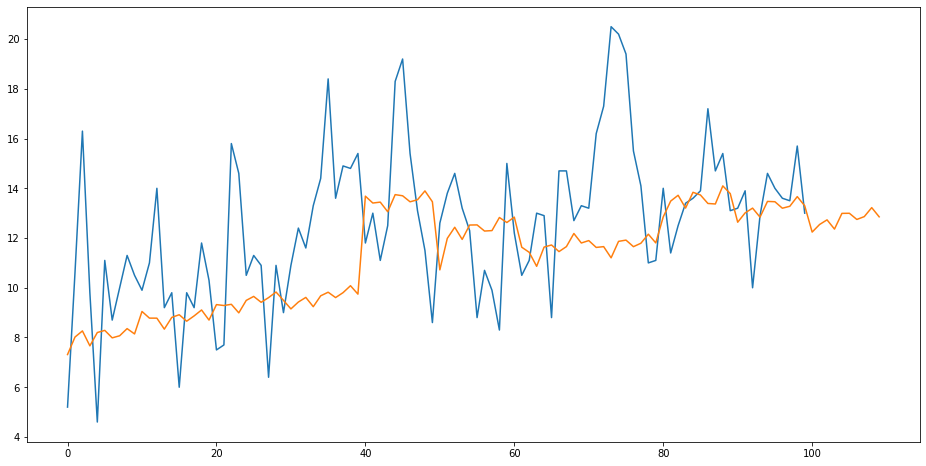

In [25]:
plt.figure(figsize=(16, 8))
plt.plot(y_test[-100:], label='true')
plt.plot(next_pred[-110:], label='predicted')
plt.show()